### Import libraries

In [261]:
import os
import sys
from datetime import datetime
import re
import yaml
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import ks_2samp, gaussian_kde
from scipy.stats import ttest_ind
from statsmodels.distributions.empirical_distribution import ECDF
import h5py as h5

# Add the parent directory of current directory to the Python path
sys.path.insert(0, os.path.abspath('..'))

from src.utils.process_session import *
from src.utils.preprocesser import *
from src.utils.optostim import *

### Set folder locations for analysed behaviour and keypoint data 

In [262]:
# folder locations for analysed data
Experiment = "DLS_GtACR_opto-inhibition"
Animals = ["SP108", "SP110", "SP112", "SP148", "SP149", "SP150", "SP151", "SP152", "SP153"] ## "SP150"
Group = ["DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR"]
Camera_Folder = "/mnt/ceph/projects/sequences/SP_FlyCap"
data_Folder = "/mnt/ceph/projects/sequences/analysed_data"
deeplabcut_folder = "/mnt/ceph/projects/sequences/SP_FlyCap"

# output folder is in data_folder/analysed_data/behaviour_output/Experiment
Output_Folder = os.path.join(data_Folder, "behaviour_output", Experiment)

In [263]:
# save path for figures
save_folder = os.path.join(Output_Folder, "plots")
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print("Created folder: ", save_folder)
else:
    print("Folder already exists: ", save_folder)

Folder already exists:  /mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/plots


In [264]:
test_animal = "SP153"

### Load files from deeplabcut_folder + test_animal


In [265]:

path_to_dlc = os.path.join(deeplabcut_folder, test_animal, "predictions")

print(f'path_to_dlc: {path_to_dlc}')

# list all h5 files in the folder
h5_files = [f for f in os.listdir(path_to_dlc) if f.endswith('.h5')]

print(h5_files)

path_to_dlc: /mnt/ceph/projects/sequences/SP_FlyCap/SP153/predictions
['camera12024-01-29T12_26_56DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-02T13_11_53DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-16T12_10_14DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-05T11_40_32DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-02-01T12_27_56DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-10T12_42_02DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-20T13_01_04DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12023-12-29T12_30_37DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-12T12_43_07DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-09T12_37_00DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-08T11_44_14DL

In [266]:
# write a function to read the dates of the video from the h5 filenames (can be one name or a list of names)
# e.g. camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5 is recorded on 2024-02-02
import re

def get_date_from_h5(h5_filenames):
    """Extracts the recording date from h5 filenames in the format
       camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5

    Args:
        h5_filenames: A single h5 filename (str) or a list of filenames (list).

    Returns:
        If a single filename is provided: The date as a string in the format YYYY-MM-DD
        If a list of filenames is provided: A list of corresponding dates.  
    """

    date_pattern = r"\d{4}-\d{2}-\d{2}"  # Pattern for YYYY-MM-DD

    if isinstance(h5_filenames, str):  # Handle a single filename
        match = re.search(date_pattern, h5_filenames)
        if match:
            return match.group(0)
        else:
            return None  # Date not found in filename

    elif isinstance(h5_filenames, list):  # Handle a list of filenames
        dates = []
        for filename in h5_filenames:
            match = re.search(date_pattern, filename)
            if match:
                dates.append(match.group(0))
            else:
                dates.append(None)  # Indicate date not found
        return dates

    else:
        raise TypeError("Input must be a string or a list of strings.")


    
# h5_filename = 'camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5'

# print(get_date_from_h5(h5_filename))


In [270]:
test_date = datetime.datetime(2024, 1, 4)
print(test_date)
print(get_date_from_h5(h5_files))
# get the h5 file for the test date
h5_file = [f for f in h5_files if get_date_from_h5(f) == test_date.strftime("%Y-%m-%d")][0]

print(h5_file)


2024-01-04 00:00:00
['2024-01-29', '2024-01-02', '2024-01-16', '2024-01-05', '2024-02-01', '2024-01-10', '2024-01-20', '2023-12-29', '2024-01-12', '2024-01-09', '2024-01-08', '2024-02-05', '2024-01-06', '2024-01-03', '2024-01-25', '2024-01-23', '2024-02-02', '2024-01-26', '2024-01-13', '2024-01-07', '2024-01-24', '2023-12-30', '2024-01-18', '2024-01-31', '2024-01-30', '2024-01-11', '2024-01-15', '2024-01-21', '2024-01-04', '2024-01-22', '2024-01-28', '2024-02-03', '2024-01-14', '2024-01-01', '2024-02-04', '2024-02-06', '2024-01-17', '2024-01-19']
camera12024-01-04T12_59_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5


In [271]:
# read the h5 file
h5_path = os.path.join(path_to_dlc, h5_file)
print(h5_path)

# read the h5 file into a pandas dataframe

keypoints_df = pd.read_hdf(h5_path)
keypoints_df.head()


/mnt/ceph/projects/sequences/SP_FlyCap/SP153/predictions/camera12024-01-04T12_59_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5


scorer    DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000  \
bodyparts                                                      nose   
coords                                                            x   
0                                                 578.301636          
1                                                 576.672424          
2                                                 577.094849          
3                                                 580.917664          
4                                                 582.972412          

scorer                                                               \
bodyparts                           left_ear                          
coords              y likelihood           x           y likelihood   
0          464.669983   0.975599  514.659485  460.311096   0.788724   
1          464.643402   0.979968  529.438721  453.496643   0.751821   
2          465.725037   0.985446  523.658508  454.758942   0.759997   
3          466.760254   0.990648  513.732788  460.524078   0.847170   
4          464.790100   0.983712  513.098389  460.043213   0.769473   

scorer                                                       ...  \
bodyparts   right_ear                        cervical_spine  ...   
coords              x           y likelihood              x  ...   
0          586.452454  524.025879   0.977400     551.241272  ...   
1          587.487488  522.901855   0.983055     550.571777  ...   
2          586.953308  522.742737   0.986593     548.458801  ...   
3          585.734131  523.667847   0.988448     546.912964  ...   
4          585.649536  523.134399   0.987255     547.413452  ...   

scorer                                                                    \
bodyparts thorasic_spine lumbar_spine                          tail_base   
coords        likelihood            x           y likelihood           x   
0               0.982345   503.629364  571.032837   0.984747  513.771362   
1               0.978609   504.408783  572.043762   0.984862  513.487122   
2               0.976207   504.184418  573.422852   0.988225  513.798401   
3               0.959744   503.302216  574.368225   0.988134  513.482544   
4               0.960179   503.090363  573.595093   0.986297  512.645203   

scorer                                                               
bodyparts                           tail_tip                         
coords              y likelihood           x           y likelihood  
0          632.158386   0.999171  753.675415  695.006470   0.997966  
1          632.704346   0.998878  753.520874  694.997559   0.998007  
2          632.738770   0.999229  753.661621  695.452942   0.997874  
3          632.806885   0.999248  753.524963  695.374939   0.997906  
4          632.207825   0.998812  753.595520  694.823547   0.998090  

[5 rows x 24 columns]

In [272]:
# make a copy of the dataframe
test_df = keypoints_df.copy()

# remove the first level of the multiindex
test_df.columns = test_df.columns.droplevel(0)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314203 entries, 0 to 314202
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   (nose, x)                     314203 non-null  float64
 1   (nose, y)                     314203 non-null  float64
 2   (nose, likelihood)            314203 non-null  float64
 3   (left_ear, x)                 314203 non-null  float64
 4   (left_ear, y)                 314203 non-null  float64
 5   (left_ear, likelihood)        314203 non-null  float64
 6   (right_ear, x)                314203 non-null  float64
 7   (right_ear, y)                314203 non-null  float64
 8   (right_ear, likelihood)       314203 non-null  float64
 9   (cervical_spine, x)           314203 non-null  float64
 10  (cervical_spine, y)           314203 non-null  float64
 11  (cervical_spine, likelihood)  314203 non-null  float64
 12  (thorasic_spine, x)           314203 non-null  fl

In [273]:
print(test_df.columns)

MultiIndex([(          'nose',          'x'),
            (          'nose',          'y'),
            (          'nose', 'likelihood'),
            (      'left_ear',          'x'),
            (      'left_ear',          'y'),
            (      'left_ear', 'likelihood'),
            (     'right_ear',          'x'),
            (     'right_ear',          'y'),
            (     'right_ear', 'likelihood'),
            ('cervical_spine',          'x'),
            ('cervical_spine',          'y'),
            ('cervical_spine', 'likelihood'),
            ('thorasic_spine',          'x'),
            ('thorasic_spine',          'y'),
            ('thorasic_spine', 'likelihood'),
            (  'lumbar_spine',          'x'),
            (  'lumbar_spine',          'y'),
            (  'lumbar_spine', 'likelihood'),
            (     'tail_base',          'x'),
            (     'tail_base',          'y'),
            (     'tail_base', 'likelihood'),
            (      'tail_tip',    

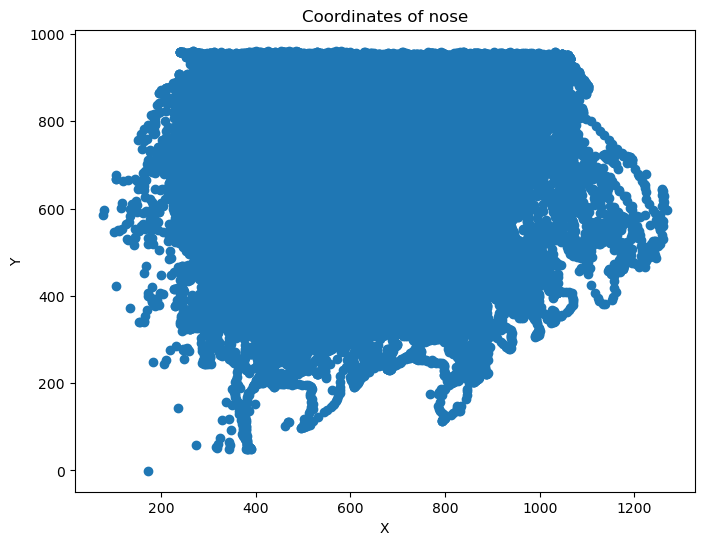

In [274]:
body_part = 'nose'

x_data = test_df[body_part, 'x']
y_data = test_df[body_part, 'y']

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(x_data, y_data)
plt.title(f'Coordinates of {body_part}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [275]:
# now loop through all Animals and concat the dataframes to create allsessions_DF

for i, current_animal in enumerate(Animals):
    print(current_animal)
    all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
    print(all_sessions_file_name)
    current_DF = pd.read_csv(all_sessions_file_name)
    if i == 0:
        allsessions_DF = current_DF
    else:
        allsessions_DF = pd.concat([allsessions_DF, current_DF], axis=0)

allsessions_DF.head()

SP108
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP108/SP108_transition_data_all_sessions.csv
SP110
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP110/SP110_transition_data_all_sessions.csv
SP112
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP112/SP112_transition_data_all_sessions.csv
SP148
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP148/SP148_transition_data_all_sessions.csv
SP149
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP149/SP149_transition_data_all_sessions.csv
SP150
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP150/SP150_transition_data_all_sessions.csv
SP151
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP151/SP151_transition_data_all_sessions.csv
SP152
/mnt/ceph/projects/sequences/analys

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
0,0,1,33,3,3,252.4712,252.4845,252.4927,254.1755,0.0082,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
1,1,1,37,3,7,252.4927,254.1755,319.3230,320.5142,65.1475,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
2,2,1,73,7,3,319.3230,320.5142,321.0197,321.0275,0.5055,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
3,3,1,33,3,3,321.0197,321.0275,321.0635,321.1840,0.0360,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
4,4,1,37,3,7,321.0635,321.1840,328.9522,330.1291,7.7682,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control


In [276]:
# get session settings loop through all Animals and concat the dataframes to create session_settings_DF
# append name of current animal to the session_settings_DF
# ignore .DS_Store files

for i, current_animal in enumerate(Animals):
    print(current_animal)
    current_DF = get_session_details(Output_Folder, current_animal)
    current_DF['Animal'] = current_animal
    if i == 0:
        session_details_DF = current_DF
    else:
        session_details_DF = pd.concat([session_details_DF, current_DF], axis=0)

session_details_DF.head()

SP108
SP110
SP112
SP148
SP149
SP150
SP151
SP152
SP153


,session_id,session,date,file_number,day,opto_session,stim_port,opto_chance,pulse_duration,pulse_interval,train_duration,train_delay,variable_train_delay,mu_variable_delay,sigma_variable_delay,lower_bound_variableDelay,upper_bound_variableDelay,experiment_type,Animal
0,0,00_20230421_104635_Fri,2023-04-21,104635,Fri,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
1,1,01_20230422_142310_Sat,2023-04-22,142310,Sat,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
2,2,02_20230422_142611_Sat,2023-04-22,142611,Sat,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
3,3,03_20230423_181053_Sun,2023-04-23,181053,Sun,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
4,4,04_20230424_110840_Mon,2023-04-24,110840,Mon,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108


In [277]:
# get the behaviour data for the test animal on test_date

test_behaviour_df = allsessions_DF[(allsessions_DF['animal_id'] == test_animal) & (allsessions_DF['date'] == test_date.strftime("%Y-%m-%d"))]
test_behaviour_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
86647,0,1,63,6,3,23.5890,24.2442,24.6467,24.6904,0.4025,...,40.7515,41.4067,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86648,1,1,33,3,3,24.6467,24.6904,24.8570,24.9509,0.1666,...,41.8092,41.8529,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86649,2,1,37,3,7,24.8570,24.9509,25.2833,25.4314,0.3324,...,42.0195,42.1134,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86650,3,1,73,7,3,25.2833,25.4314,26.1900,26.2349,0.7586,...,42.4458,42.5939,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86651,4,1,32,3,2,26.1900,26.2349,26.4395,26.5836,0.2046,...,43.3525,43.3974,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control


In [278]:
# get all non-stimulated trials when test_behaviour_df['opto_condition is not 1
nonstim_df = test_behaviour_df[test_behaviour_df['opto_condition'] != 1]
nonstim_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
86670,23,3,22,2,2,39.0490,39.1383,47.7545,47.9404,8.6162,...,56.212000,56.301300,56.212000,61.592500,11231,29,2024-01-04,Thu,SP153,Control
86678,31,5,21,2,1,54.0132,54.0904,54.4565,54.5389,0.3661,...,71.170625,71.247825,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control
86679,32,5,16,1,6,54.4565,54.5389,54.8337,54.8956,0.2948,...,71.613925,71.696325,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control
86680,33,5,63,6,3,54.8337,54.8956,55.4067,55.4606,0.5111,...,71.991125,72.053025,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control
86681,34,5,37,3,7,55.4067,55.4606,55.7002,57.8948,0.2396,...,72.564125,72.618025,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control


In [279]:
stim_df = test_behaviour_df[test_behaviour_df['opto_condition'] == 1]
stim_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
86647,0,1,63,6,3,23.5890,24.2442,24.6467,24.6904,0.4025,...,40.7515,41.4067,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86648,1,1,33,3,3,24.6467,24.6904,24.8570,24.9509,0.1666,...,41.8092,41.8529,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86649,2,1,37,3,7,24.8570,24.9509,25.2833,25.4314,0.3324,...,42.0195,42.1134,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86650,3,1,73,7,3,25.2833,25.4314,26.1900,26.2349,0.7586,...,42.4458,42.5939,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86651,4,1,32,3,2,26.1900,26.2349,26.4395,26.5836,0.2046,...,43.3525,43.3974,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control


In [340]:
# get a random trail id from nonstim_df

trial_id = 248
# print(trial_id)

trial_df = stim_df[stim_df['trial_id'] == trial_id]
trial_df

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
88338,1691,248,32,3,2,1391.9527,1391.9712,1392.3016,1392.4363,0.3304,...,1409.158475,1409.176975,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88339,1692,248,21,2,1,1392.3016,1392.4363,1392.7555,1392.8282,0.3192,...,1409.507375,1409.642075,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88340,1693,248,17,1,7,1392.7555,1392.8282,1395.1097,1395.2199,2.2815,...,1409.961275,1410.033975,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88341,1694,248,72,7,2,1395.1097,1395.2199,1395.9338,1396.0421,0.7139,...,1412.315475,1412.425675,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88342,1695,248,21,2,1,1395.9338,1396.0421,1396.4180,1396.4374,0.3759,...,1413.139575,1413.247875,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88343,1696,248,11,1,1,1396.4180,1396.4374,1396.4737,1396.4863,0.0363,...,1413.623775,1413.643175,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88344,1697,248,16,1,6,1396.4737,1396.4863,1396.7669,1396.9200,0.2806,...,1413.679475,1413.692075,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88345,1698,248,63,6,3,1396.7669,1396.9200,1397.3577,1397.3645,0.4377,...,1413.972675,1414.125775,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88346,1699,248,37,3,7,1397.3577,1397.3645,1397.6215,1399.5152,0.2570,...,1414.563475,1414.570275,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control
88347,1700,248,72,7,2,1397.6215,1399.5152,1399.8110,1399.8814,0.2958,...,1414.827275,1416.720975,1409.507375,1415.221,11476,29,2024-01-04,Thu,SP153,Control


In [341]:
camera_start = trial_df['camera_trial_start_times'].values[0]
camera_end = trial_df['camera_trial_end_times'].values[0]

next_trial_camera_start = test_behaviour_df[test_behaviour_df['trial_id'] == trial_id + 1]['camera_trial_start_times'].values[0]

print(camera_start, camera_end)
print(next_trial_camera_start)

1409.507375 1415.221
1417.02


In [342]:
# now the aim is to exctract the frames that correspond to the trial from the video
# convert frmae numbers to numpy array
# row numbers of test_df that correspond to the frame numbers

frame_numbers = test_df.index.get_level_values(0).to_numpy()



In [343]:
# load files from timestamps folder inside Output_Folder+current_animal+deeplabcut_folder

timestamps_folder = os.path.join(deeplabcut_folder, test_animal)
#check if the folder exists
if not os.path.exists(timestamps_folder):
    print(f"Folder does not exist: {timestamps_folder}")
elif os.path.exists(timestamps_folder):
    print(f"Folder exists: {timestamps_folder}")

# list all files in the folder
timestamps_files = [f for f in os.listdir(timestamps_folder) if f.endswith('.csv')]
print(timestamps_files)

Folder exists: /mnt/ceph/projects/sequences/SP_FlyCap/SP153
['stamps2024-01-24T15_30_16.csv', 'stamps2024-01-08T11_44_14.csv', 'stamps2024-01-13T13_19_19.csv', 'stamps2024-01-22T13_40_05.csv', 'stamps2024-01-15T12_50_30.csv', 'stamps2024-02-02T12_19_31.csv', 'stamps2024-01-01T13_02_40.csv', 'stamps2024-01-19T12_58_41.csv', 'stamps2024-02-04T13_43_27.csv', 'stamps2024-01-31T11_58_22.csv', 'stamps2024-01-17T13_16_43.csv', 'stamps2024-01-09T12_36_59.csv', 'stamps2024-01-10T12_42_02.csv', 'stamps2024-02-06T13_04_00.csv', 'stamps2024-01-12T12_43_06.csv', 'stamps2023-12-30T13_21_19.csv', 'stamps2024-02-03T13_21_08.csv', 'stamps2024-01-02T13_11_52.csv', 'stamps2024-01-20T13_01_04.csv', 'stamps2024-01-26T14_03_37.csv', 'stamps2024-01-28T14_29_14.csv', 'stamps2023-12-29T12_30_37.csv', 'stamps2024-01-03T13_03_34.csv', 'stamps2024-01-04T12_59_31.csv', 'stamps2024-01-21T12_08_36.csv', 'stamps2024-01-16T12_10_14.csv', 'stamps2024-01-29T12_26_56.csv', 'stamps2024-01-23T12_01_39.csv', 'stamps2024-01-

In [344]:
# date of the session
query_date = trial_df['date'].values[0]
# query_date = '2024-01-29'
print(query_date)
print(type(query_date))
def get_timestamps_filename(timestamps_files, date):
    date_pattern = r"stamps" + date + r"T\d{2}_\d{2}_\d{2}\.csv"  
    for filename in timestamps_files:
        match = re.match(date_pattern, filename)
        if match:
            return match.group(0)  # Return the full matching filename

    return None  # No match found

timestamps_file = get_timestamps_filename(timestamps_files, query_date) 
print(timestamps_file)

2024-01-04
<class 'str'>
stamps2024-01-04T12_59_31.csv


In [345]:
# load the timestamps file
timestamps_path = os.path.join(timestamps_folder, timestamps_file)

timestamps = pd.read_csv(timestamps_path, delimiter=' ', header=None)
timestamps.head()

,0,1,2,3
0,805306368,306483669,5471544,NaN
1,805306368,307029242,5471545,NaN
2,805306368,307574809,5471546,NaN
3,805306368,308120391,5471547,NaN
4,805306368,308666988,5471548,NaN


In [346]:
timestamps = timestamps.drop(columns=[3])  # Drop the last column
timestamps.columns = ['pin_state', 'timestamp', 'frame_number']
timestamps['pin_state_bool'] = timestamps['pin_state'] != timestamps['pin_state'][0]

# Convert timestamps to seconds and uncycle
timestamp_array = timestamps['timestamp'].values
timestamps_in_seconds_uncycled = convert_and_uncycle_timestamps(timestamp_array)
timestamps['time_seconds'] = timestamps_in_seconds_uncycled
# make the first frame number 0
timestamps['frame_number'] = timestamps['frame_number'] - timestamps['frame_number'].iloc[0]

timestamps.head()


,pin_state,timestamp,frame_number,pin_state_bool,time_seconds
0,805306368,306483669,0,False,9.137125
1,805306368,307029242,1,False,9.153750
2,805306368,307574809,2,False,9.170375
3,805306368,308120391,3,False,9.187000
4,805306368,308666988,4,False,9.203750


In [347]:
# find frame numbers that correspond to the trial camera start and end times

camera_start = trial_df['camera_trial_start_times'].values[0]
camera_end = trial_df['camera_trial_end_times'].values[0]

next_trial_camera_start = test_behaviour_df[test_behaviour_df['trial_id'] == trial_id + 1]['camera_trial_start_times'].values[0]

print(camera_start, camera_end)
print(next_trial_camera_start)

# in the timestamps dataframe find the row for which the time_second is in the range of camera_start and camera_end
trial_timestamps = timestamps[(timestamps['time_seconds'] >= camera_start) & (timestamps['time_seconds'] <= next_trial_camera_start)]
trial_timestamps


1409.507375 1415.221
1417.02


,pin_state,timestamp,frame_number,pin_state_bool,time_seconds
84067,805306368,50180326,84067,False,1409.507375
84068,805306368,50725899,84068,False,1409.524000
84069,805306368,51271473,84069,False,1409.540625
84070,805306368,51817047,84070,False,1409.557250
84071,805306368,52363645,84071,False,1409.574000
...,...,...,...,...,...
84514,2952790016,299676639,84514,True,1416.953375
84515,2952790016,300222213,84515,True,1416.970000
84516,2952790016,300767794,84516,True,1416.986625
84517,2952790016,302100817,84517,True,1417.003375


In [348]:
# frames to extract
frames_to_extract = trial_timestamps['frame_number'].values


# exctract these frames from test_df
trial_df_keys = test_df.loc[frames_to_extract]
trial_df_keys.head()


bodyparts        nose                           left_ear              \
coords              x           y likelihood           x           y   
84067      586.092712  461.183594   0.989827  561.128967  501.728912   
84068      582.657715  460.050934   0.990931  557.526550  503.930573   
84069      582.249329  460.191193   0.991335  555.057129  505.281403   
84070      581.740906  459.168854   0.992105  553.040100  508.339020   
84071      577.099365  458.702209   0.994547  551.816711  511.081238   

bodyparts              right_ear                        cervical_spine  ...  \
coords    likelihood           x           y likelihood              x  ...   
84067       0.964489  660.326233  483.364960   0.986648     598.055054  ...   
84068       0.964194  659.084473  482.356720   0.982826     596.006531  ...   
84069       0.971290  655.408936  480.703308   0.980059     595.161438  ...   
84070       0.975484  652.554749  477.639801   0.977712     595.566772  ...   
84071       0.978085  646.683899  477.961029   0.986217     592.495239  ...   

bodyparts thorasic_spine lumbar_spine                          tail_base  \
coords        likelihood            x           y likelihood           x   
84067           0.944033   602.696411  570.173828   0.983930  580.458130   
84068           0.944785   604.060974  568.929688   0.981150  581.490662   
84069           0.932498   604.164062  569.177490   0.979594  581.748047   
84070           0.953757   604.500671  571.224487   0.984109  582.156372   
84071           0.957819   606.052185  574.323914   0.983730  584.244324   

bodyparts                           tail_tip                         
coords              y likelihood           x           y likelihood  
84067      622.903198   0.999077  556.843140  836.035583   0.996292  
84068      622.767578   0.998924  556.534302  836.190125   0.995889  
84069      622.779175   0.998726  557.017456  835.740234   0.995354  
84070      623.683899   0.998879  556.611572  835.845215   0.995767  
84071      625.986084   0.998858  556.615173  835.437012   0.995582  

[5 rows x 24 columns]

In [349]:
# get the port events for the trial in timestamps

port_times = trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]
print(port_times)

# get the port numbers for the trial
port_numbers = trial_df['start_poke_port'].values
print(port_numbers)

# create a dictionary with port numbers as keys and port names as values
port_dict = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5', 4: 'port x', 5: 'port y', 8: 'port z'}

port_colors = {2: 'blue', 1: 'green', 6: 'red', 3: 'orange', 7: 'purple', 4: 'brown', 5: 'pink', 8: 'grey'}

[0.     0.3489 0.8028 3.157  3.9811 4.4653 4.521  4.8142 5.405  5.6688]
[3 2 1 7 2 1 1 6 3 7]


In [350]:
# takle the centroid of 3 bpdy parts for x_data and y_data
x_nose = trial_df_keys['nose', 'x']
y_nose = trial_df_keys['nose', 'y']

x_left_ear = trial_df_keys['left_ear', 'x']
y_left_ear = trial_df_keys['left_ear', 'y']

x_right_ear = trial_df_keys['right_ear', 'x']
y_right_ear = trial_df_keys['right_ear', 'y']

x_data = (x_nose + x_left_ear + x_right_ear) / 3
y_data = (y_nose + y_left_ear + y_right_ear) / 3

{'time': array([0.    , 0.3489, 0.8028, 3.157 , 3.9811, 4.4653, 4.521 , 4.8142,
       5.405 , 5.6688]), 'port': array([3, 2, 1, 7, 2, 1, 1, 6, 3, 7])}
[602.51597087 530.17715894 508.69956608 659.3996993  532.54274148
 568.06347274 567.70879476 632.87224113 673.65228475 675.4172526 ] [482.09248861 495.23830162 494.07127116 486.78476013 490.13667448
 439.17888031 426.92296244 479.35323181 425.40888875 421.35136434]


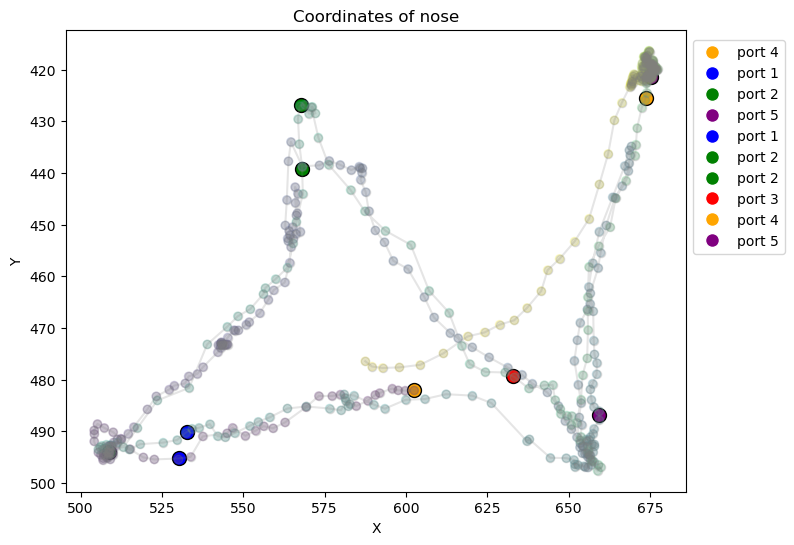

In [351]:
# plot the nose coordinates, line plot
# x_data = trial_df_keys[body_part, 'x']
# y_data = trial_df_keys[body_part, 'y']
port_data = {'time': port_times, 'port': port_numbers}
print(port_data)

time_data = trial_df_keys.index.get_level_values(0).to_numpy()
# print(time_data)

# make the first time point 0
time_data = time_data - time_data[0]
# print(time_data)
# convert time_data to seconds considering the frame rate 60fps
time_data_seconds = time_data / 60

# get the x, y co-ordinates for the port times
port_x = np.interp(port_times, time_data_seconds, x_data)
port_y = np.interp(port_times, time_data_seconds, y_data)
print(port_x, port_y)

# colour the first and last points differently in a gradient
colour = np.linspace(0, 1, len(x_data))


plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(x_data, y_data, marker='o', color='grey', alpha=0.2)
# plot the port events
for i, port in enumerate(port_numbers):
    plt.scatter(x=port_x[i], y=port_y[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

plt.scatter(x_data, y_data, c=colour, cmap='viridis', alpha=0.2)
plt.title(f'Coordinates of {body_part}')
# invert the y axis
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


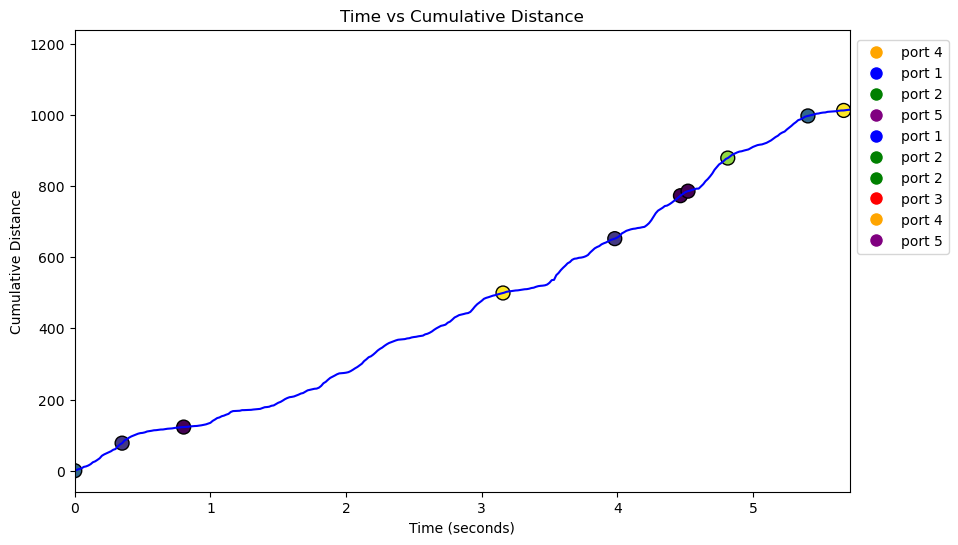

In [352]:
# linearize the x-data and y-data
# plot time vs x and y

time_data = trial_df_keys.index.get_level_values(0).to_numpy()
# print(time_data)

# make the first time point 0
time_data = time_data - time_data[0]
# print(time_data)
# convert time_data to seconds considering the frame rate 60fps
time_data_seconds = time_data / 60
# print(time_data_seconds)

port_times = trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]

# Assuming x_data and y_data are already defined as numpy arrays or need to be converted
x_data = np.array(x_data) if not isinstance(x_data, np.ndarray) else x_data
y_data = np.array(y_data) if not isinstance(y_data, np.ndarray) else y_data


# Initialize the cumulative distance array with zeros
cumulative_distance = np.zeros(len(x_data))


# Compute the cumulative distance for each point from the starting point
for i in range(1, len(x_data)):
    distance = np.sqrt((x_data[i] - x_data[i-1])**2 + (y_data[i] - y_data[i-1])**2)
    cumulative_distance[i] = cumulative_distance[i-1] + distance

# Interpolate the cumulative distance at the port times so that they fall on the same line as the x and y data
cumulative_distance_port = np.interp(port_times, time_data_seconds, cumulative_distance)

# Now, plot the cumulative distance over time
plt.figure(figsize=(10, 6))

# Plotting the cumulative distance against time
plt.plot(time_data_seconds, cumulative_distance, label='Cumulative Distance', color='blue')
# Plotting the cumulative distance against time for the port events
plt.scatter(port_times, cumulative_distance_port, c=port_numbers, cmap='viridis', label='Port Events', s=100, edgecolors='black', linewidths=1)
plt.title('Time vs Cumulative Distance')
plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Distance')
# shortcut to not show the time aftre the last poke
plt.xlim(0, camera_end - camera_start)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

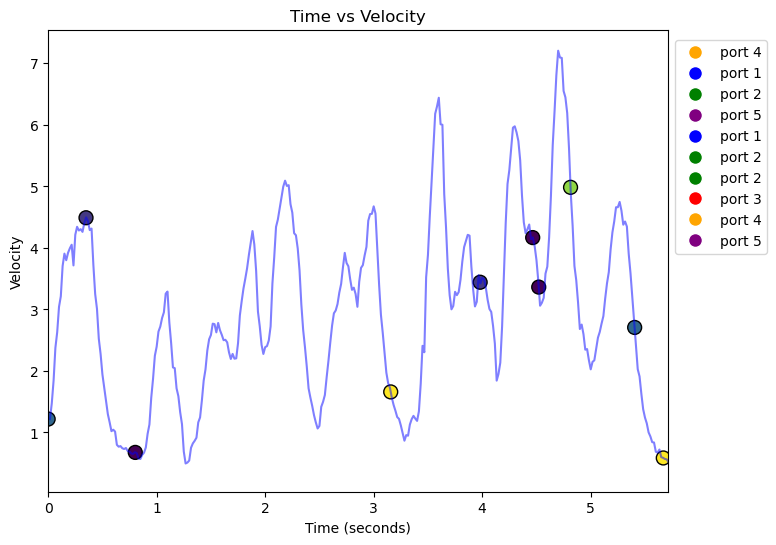

In [353]:
# make velocity of x and y
x_velocity = np.diff(x_data)
y_velocity = np.diff(y_data)


# Initialize the cumulative distance array with zeros
cumulative_distance = np.zeros(len(x_data))

# calculate the velocity
velocity = np.sqrt(x_velocity**2 + y_velocity**2)
# smooth the velocity every 20 points
velocity = np.convolve(velocity, np.ones(10)/10, mode='same')

# port times
port_times = trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]

# calculate the velocity at the port times
velocity_port = np.interp(port_times, time_data_seconds[1:], velocity)


# plot the velocity over time
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plotting the velocity against time
plt.plot(time_data_seconds[1:], velocity, label='Velocity', color='blue', alpha=0.5)
# Plotting the velocity against time for the port events
plt.scatter(port_times, velocity_port, c=port_numbers, cmap='viridis', label='Port Events', s=100, edgecolors='black', linewidths=1)
plt.title('Time vs Velocity')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity')
# shortcut to not include the data from the next trial
plt.xlim(0, camera_end - camera_start)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

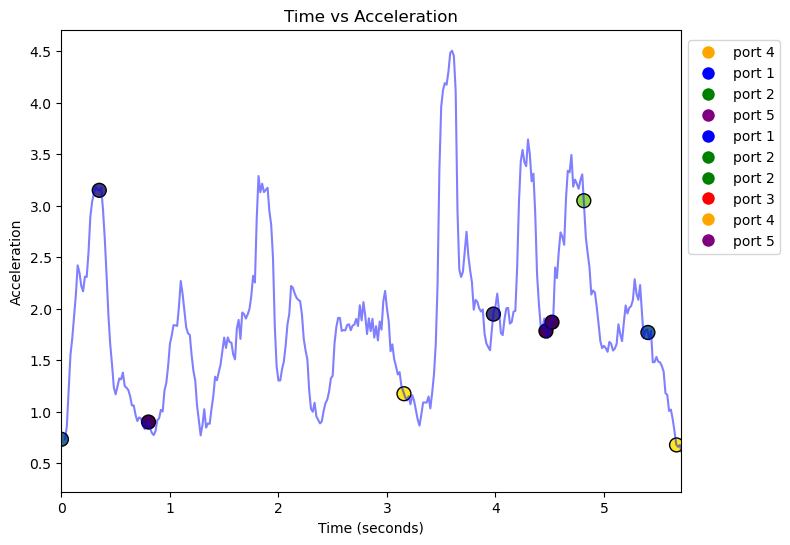

In [354]:
# plot acceleration over time

# calculate the acceleration
x_acceleration = np.diff(x_velocity)
y_acceleration = np.diff(y_velocity)

# Initialize the cumulative distance array with zeros
cumulative_distance = np.zeros(len(x_data))

# calculate the acceleration
acceleration = np.sqrt(x_acceleration**2 + y_acceleration**2)
# smooth the acceleration
acceleration = np.convolve(acceleration, np.ones(10)/10, mode='same')

# port times
port_times = trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]

# calculate the acceleration at the port times
acceleration_port = np.interp(port_times, time_data_seconds[2:], acceleration)

# plot the acceleration over time
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plotting the acceleration against time
plt.plot(time_data_seconds[2:], acceleration, label='Acceleration', color='blue', alpha=0.5)
# Plotting the acceleration against time for the port events
plt.scatter(port_times, acceleration_port, c=port_numbers, cmap='viridis', label='Port Events', s=100, edgecolors='black', linewidths=1)
plt.title('Time vs Acceleration')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
# shortcut to not include the data from the next trial
plt.xlim(0, camera_end - camera_start)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()